In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
import data
import models
import paths
import routine
import viz_tools

# Train on LA5 dataset

We train on rest and test on task with zero participants intersection

Dataset size: 147
Labels distribution: (array([0, 1]), array([119,  28]))
Image shape: (16, 1, 51, 63, 43)
Target: 0


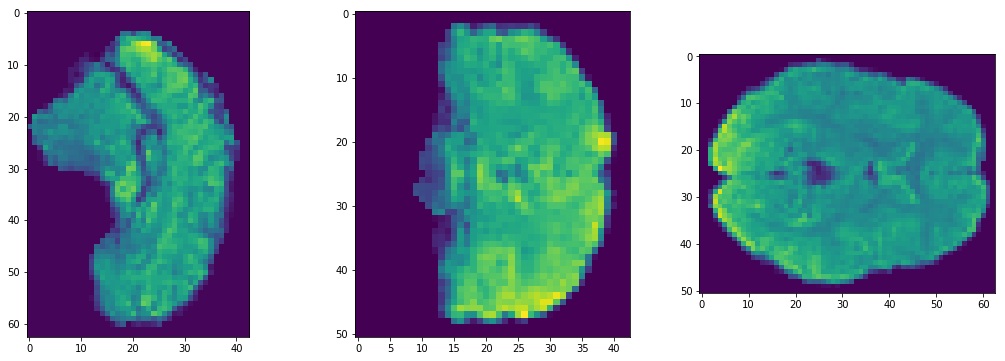

In [5]:
la5_rest_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.la5_rest_fmri_file_suffix,
    brain_mask_suffix=paths.la5_rest_fmri_brain_mask_suffix,
    coord_min=(7, 7, 0),
    img_shape=(51, 63, 43),
    seq_len=16,
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
print("Dataset size: {}".format(len(la5_rest_dataset)))
print("Labels distribution: {}".format(np.unique(la5_rest_dataset.labels, return_counts=True)))
img, target = la5_rest_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img, t=-1)

Dataset size: 147
Labels distribution: (array([0, 1]), array([120,  27]))
Image shape: (16, 1, 51, 63, 43)
Target: 0


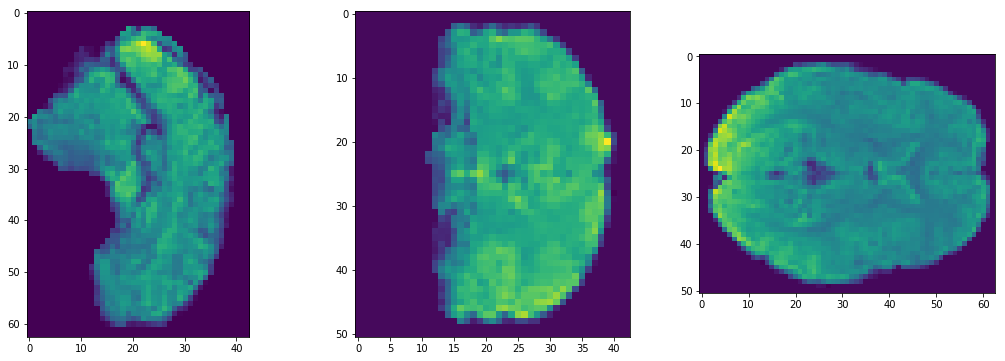

In [6]:
la5_task_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.la5_task_fmri_file_suffix,
    brain_mask_suffix=paths.la5_task_fmri_brain_mask_suffix,
    coord_min=(7, 7, 0),
    img_shape=(51, 63, 43),
    seq_len=16,
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
print("Dataset size: {}".format(len(la5_task_dataset)))
print("Labels distribution: {}".format(np.unique(la5_task_dataset.labels, return_counts=True)))
img, target = la5_task_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img, t=-1)

# Some participants change labels between rest and task?

In [23]:
rest0 = set(la5_rest_dataset.pids[la5_rest_dataset.labels==0])
task0 = set(la5_task_dataset.pids[la5_task_dataset.labels==0])
rest0 - task0, task0 - rest0

({'sub-10345', 'sub-10891'}, {'sub-10193', 'sub-10948', 'sub-11082'})

In [24]:
rest1 = set(la5_rest_dataset.pids[la5_rest_dataset.labels==1])
task1 = set(la5_task_dataset.pids[la5_task_dataset.labels==1])
rest1 - task1, task1 - rest1

({'sub-50032'}, set())

In [7]:
assert la5_task_dataset.img_shape == la5_rest_dataset.img_shape
assert la5_task_dataset.seq_len == la5_rest_dataset.seq_len

In [8]:
def create_model_opt():
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.ConvLSTM(la5_rest_dataset.img_shape, n_outputs=2, hidden_size=128, n_layers=1,
                            n_fc_units_rnn=512, dropout=0, stride=1, n_filters=16, n_blocks=3)
    opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

Epoch 21 of 100 took 79.361s
  training loss (in-iteration): 	0.071921
  validation loss: 			0.547886
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.75


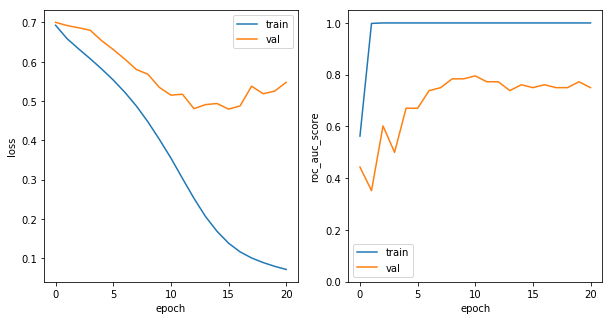

<Figure size 720x360 with 0 Axes>

Early stopping! Patience is out.
val roc_auc_scores: [0.6458333333333334, 0.8472222222222222, 0.9097222222222223, 0.8869565217391304, 0.7954545454545454]
val roc_auc_score mean: 0.8170377689942907
val roc_auc_score std: 0.09398610046233151


In [9]:
# ~2h20min
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, la5_rest_dataset, cv, device, metric, batch_size=10, val_dataset=la5_task_dataset)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

### train on whole LA5 rest dataset and save

In [9]:
model_save_path = "./models/conv_lstm_pretrained_la5.pth"

Epoch 15 of 15 took 74.942s
  training loss (in-iteration): 	0.110229
  training roc_auc_score: 			1.00


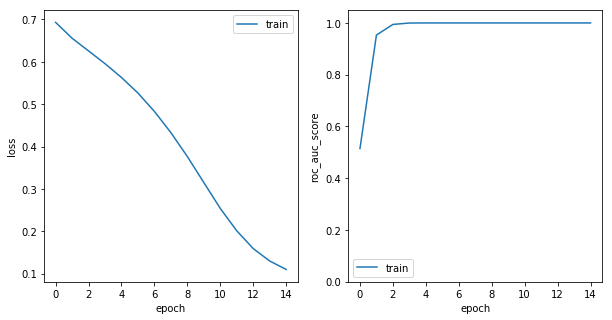

<Figure size 720x360 with 0 Axes>

In [15]:
model, optimizer = create_model_opt()
metric = roc_auc_score
train_idx = np.arange(len(la5_rest_dataset))
np.random.seed(0)
np.random.shuffle(train_idx)
train_idx = routine.stratified_batch_indices(train_idx, la5_rest_dataset.labels)
train_loader = DataLoader(Subset(la5_rest_dataset, train_idx),
                          shuffle=False,
                          batch_size=10,
                          drop_last=False)
_ = routine.train(model, optimizer, train_loader, None, device, metric, verbose=1, model_save_path=model_save_path, max_epoch=15)

In [16]:
del model, optimizer, train_loader

# Test on Siblings dataset (without domain adaptation)

In [10]:
import torchvision.transforms as transforms
import functools

Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))
Image shape: torch.Size([16, 1, 51, 63, 43])
Target: 1


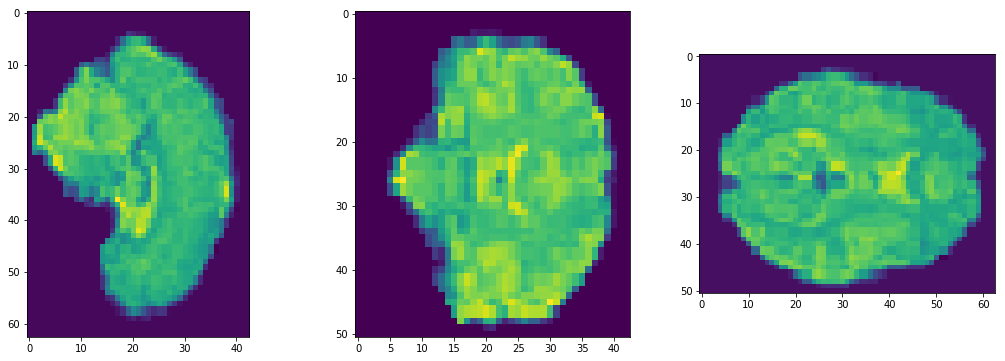

In [11]:
sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="fMRI",
    mri_file_suffix=paths.sibl_fmri_file_suffix,
    brain_mask_suffix=paths.sibl_fmri_brain_mask_suffix,
    coord_min=(4,3,0),
    img_shape=(40,52,43),
#     img_shape=(100,100,100),
    seq_len=16,
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
    transform=transforms.Compose([
        functools.partial(torch.FloatTensor),
        functools.partial(torch.nn.functional.interpolate, size=la5_rest_dataset.img_shape, mode='nearest'),
    ])
)
print("Dataset size: {}".format(len(sibl_dataset)))
print("Labels distribution: {}".format(np.unique(sibl_dataset.labels, return_counts=True)))
img, target = sibl_dataset[1]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img, t=-1)

In [12]:
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
                                      batch_size=10, model_load_path=model_save_path)

# for transfer learning
# freeze layers in a create_model_opt
# val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric,
#                                       batch_size=10, model_load_path=None)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [00:03<00:00,  1.94s/it]

val roc_auc_scores: [0.625]
val roc_auc_score mean: 0.625
val roc_auc_score std: 0.0


# Test on one another dataset (without domain adaptation)

In [15]:
# insert here

# Conclusion

One can notice a significant drop in performance. This problem we aim to solve.